## Object Detection Inference

In [54]:
import tensorflow as tf
import tensorflow_hub as hub
from PIL import Image
from PIL import ImageOps
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"

In [3]:
model = hub.load(module_handle)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [5]:
model.signatures.keys()

KeysView(_SignatureMap({'default': <ConcreteFunction pruned(images) at 0x7F3378578A00>}))

In [6]:
detector = model.signatures['default']

In [7]:
def download_and_resize_image(url, new_width=256, new_height=256):
    '''
    Fetches an image online, resizes it and saves it locally.
    
    Args:
        url (string) -- link to the image
        new_width (int) -- size in pixels used for resizing the width of the image
        new_height (int) -- size in pixels used for resizing the length of the image
        
    Returns:
        (string) -- path to the saved image
    '''
    # create a temporary file ending with ".jpg"
    _, filename = tempfile.mkstemp(suffix=".jpg")
    
    # opens the given URL
    response = urlopen(url)
    
    # reads the image fetched from the URL
    image_data = response.read()
    
    # puts the image data in memory buffer
    image_data = BytesIO(image_data)
    
    # opens the image
    pil_image = Image.open(image_data)
    
    # resizes the image. will crop if aspect ratio is different.
    pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
    
    # converts to the RGB colorspace
    pil_image_rgb = pil_image.convert("RGB")
    
    # saves the image to the temporary file created earlier
    pil_image_rgb.save(filename, format="JPEG", quality=90)
    
    print("Image downloaded to %s." % filename)
    
    return filename

In [11]:
# You can choose a different URL that points to an image of your choice
image_url = "https://upload.wikimedia.org/wikipedia/commons/f/fb/20130807_dublin014.JPG"

# download the image and use the original height and width
downloaded_image_path = download_and_resize_image(image_url, 3872, 2592)

Image downloaded to /tmp/tmp1nct_446.jpg.


In [12]:
def load_img(path):
    '''
    Loads a JPEG image and converts it to a tensor.
    
    Args:
        path (string) -- path to a locally saved JPEG image
    
    Returns:
        (tensor) -- an image tensor
    '''
    # read the file
    img = tf.io.read_file(path)
    # convert to a tensor
    img = tf.image.decode_jpeg(img, channels=3)
    return img

In [49]:
img = Image.open(downloaded_image_path)

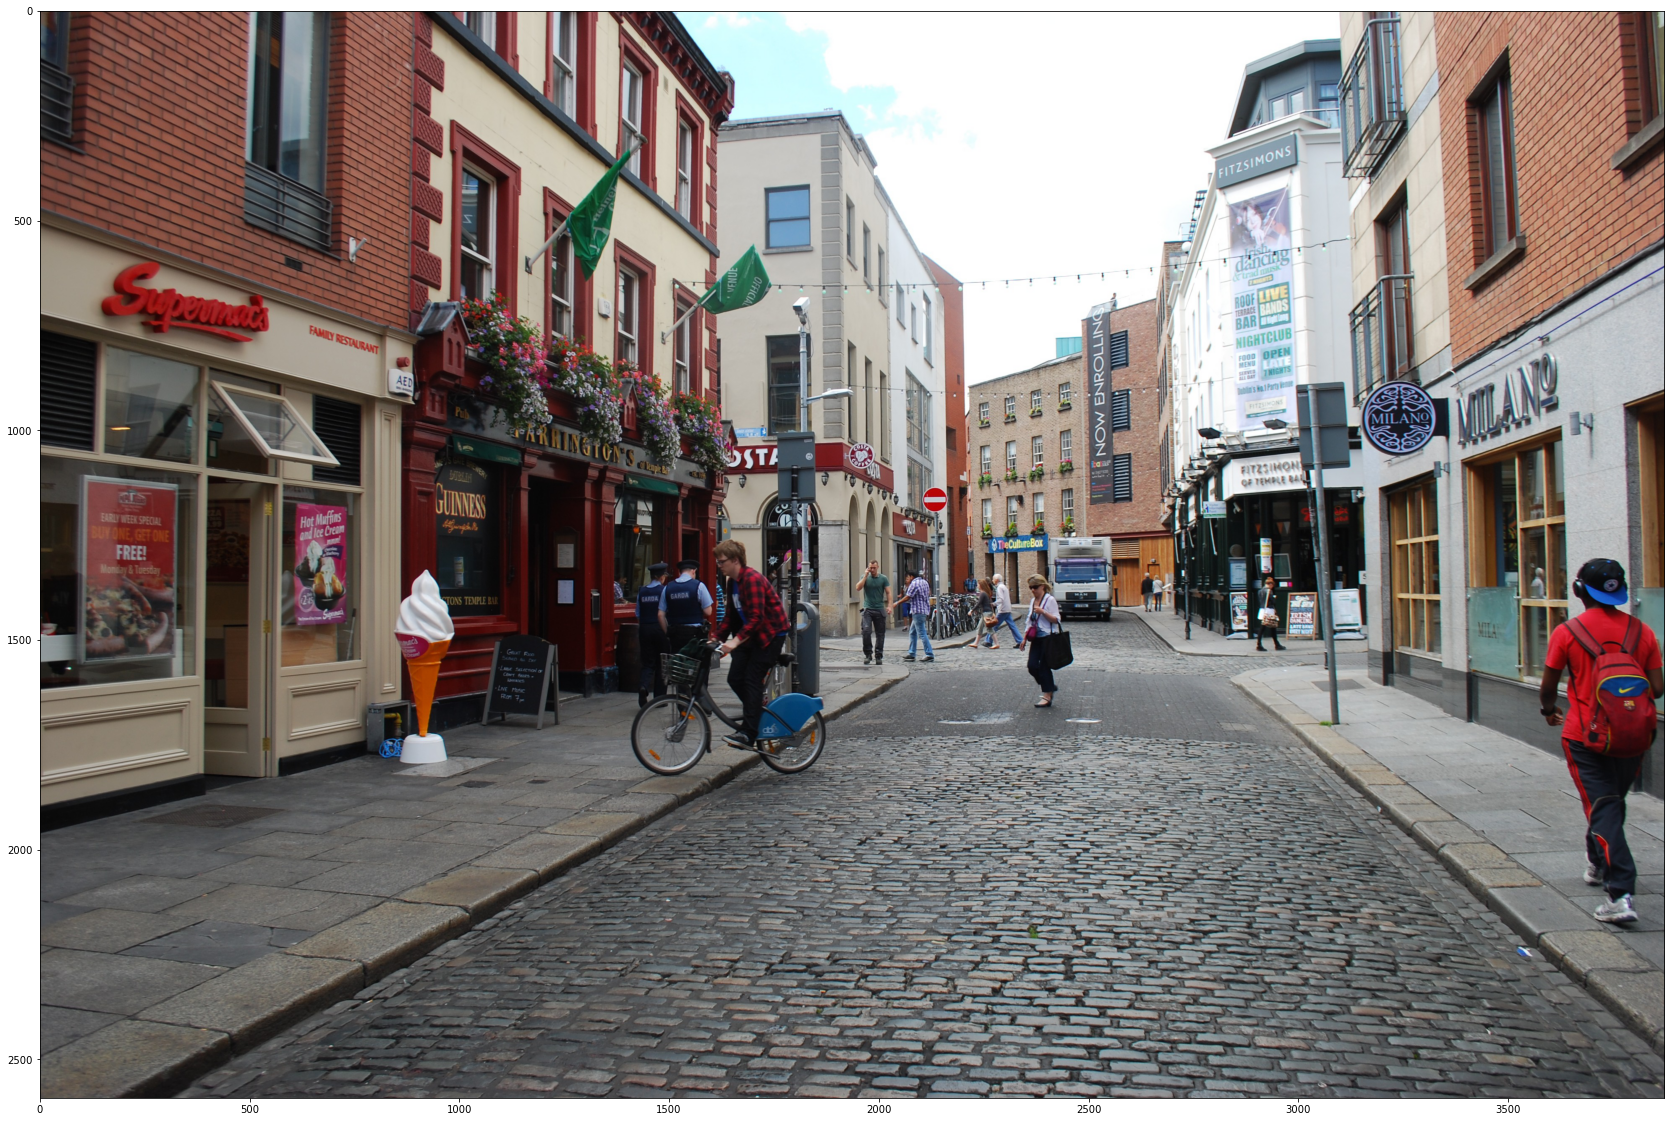

In [50]:
plt.figure(figsize=(30,20))
plt.imshow(img)

In [21]:
def run_detector(detector, path):
    img = load_img(path)
    converted_img = tf.image.convert_image_dtype(img, tf.float32)
    converted_img = converted_img[tf.newaxis, ...]
    print(converted_img.shape)
    result = detector(converted_img)
    result = {key:value.numpy() for key, value in result.items()}
    
    return result

In [23]:
result = run_detector(detector, downloaded_image_path)

(1, 2592, 3872, 3)


In [24]:
print(result.keys())

dict_keys(['detection_class_labels', 'detection_class_entities', 'detection_boxes', 'detection_scores', 'detection_class_names'])


In [25]:
print(result['detection_class_entities'])
print(result['detection_scores'])
print(result['detection_boxes'])

[b'Person' b'Person' b'Person' b'Person' b'Footwear' b'Person' b'Building'
 b'Bicycle' b'Window' b'Building' b'Person' b'Wheel' b'Building'
 b'Building' b'Person' b'Wheel' b'Building' b'Window' b'Window'
 b'Building' b'Person' b'Van' b'Person' b'Bicycle wheel' b'Person'
 b'Window' b'Window' b'Bicycle' b'Building' b'Window' b'Window' b'Man'
 b'Person' b'Person' b'Woman' b'Clothing' b'Bicycle wheel' b'Window'
 b'Person' b'Window' b'Land vehicle' b'Land vehicle' b'Clothing'
 b'Bicycle' b'Window' b'House' b'Land vehicle' b'Land vehicle' b'House'
 b'Man' b'Window' b'Clothing' b'Footwear' b'Person' b'Window' b'Man'
 b'Man' b'House' b'Person' b'Building' b'Clothing' b'Window' b'Person'
 b'Jeans' b'Man' b'Furniture' b'Person' b'Person' b'Person'
 b'Land vehicle' b'Person' b'Window' b'House' b'Woman' b'Window' b'Man'
 b'Person' b'Man' b'Clothing' b'Bicycle' b'Man' b'Person' b'Window'
 b'Person' b'Car' b'Man' b'Car' b'Chair' b'House' b'Window' b'Clothing'
 b'Tire' b'Clothing' b'Window' b'Land ve

In [101]:
def draw_bounding_boxes(img, result, threshold):
    plt.figure(figsize=(30,20))
    w, h = img.size
    items = len(result['detection_boxes'])
    for i in range(items):
        if result['detection_scores'][i] < threshold:
            continue
        label = result['detection_class_entities'][i].decode('utf8')
        norm_bboxs = result['detection_boxes'][i]
        bboxs = np.array([norm_bboxs[0]*h, norm_bboxs[1]*w, norm_bboxs[2]*h, norm_bboxs[3]*w])
        bboxs = (bboxs).astype(int)
        img = np.array(img)
        ymin, xmin, ymax, xmax = bboxs
        img = cv2.rectangle(img, (xmin, ymin), (xmax, ymax),(255,0,0), 3)
        if ymin - 10 > 60:
            cv2.putText(img, label, (xmin, ymin-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3)
        else:
            cv2.putText(img, label, (xmin, ymin+60), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3)
    plt.imshow(img)

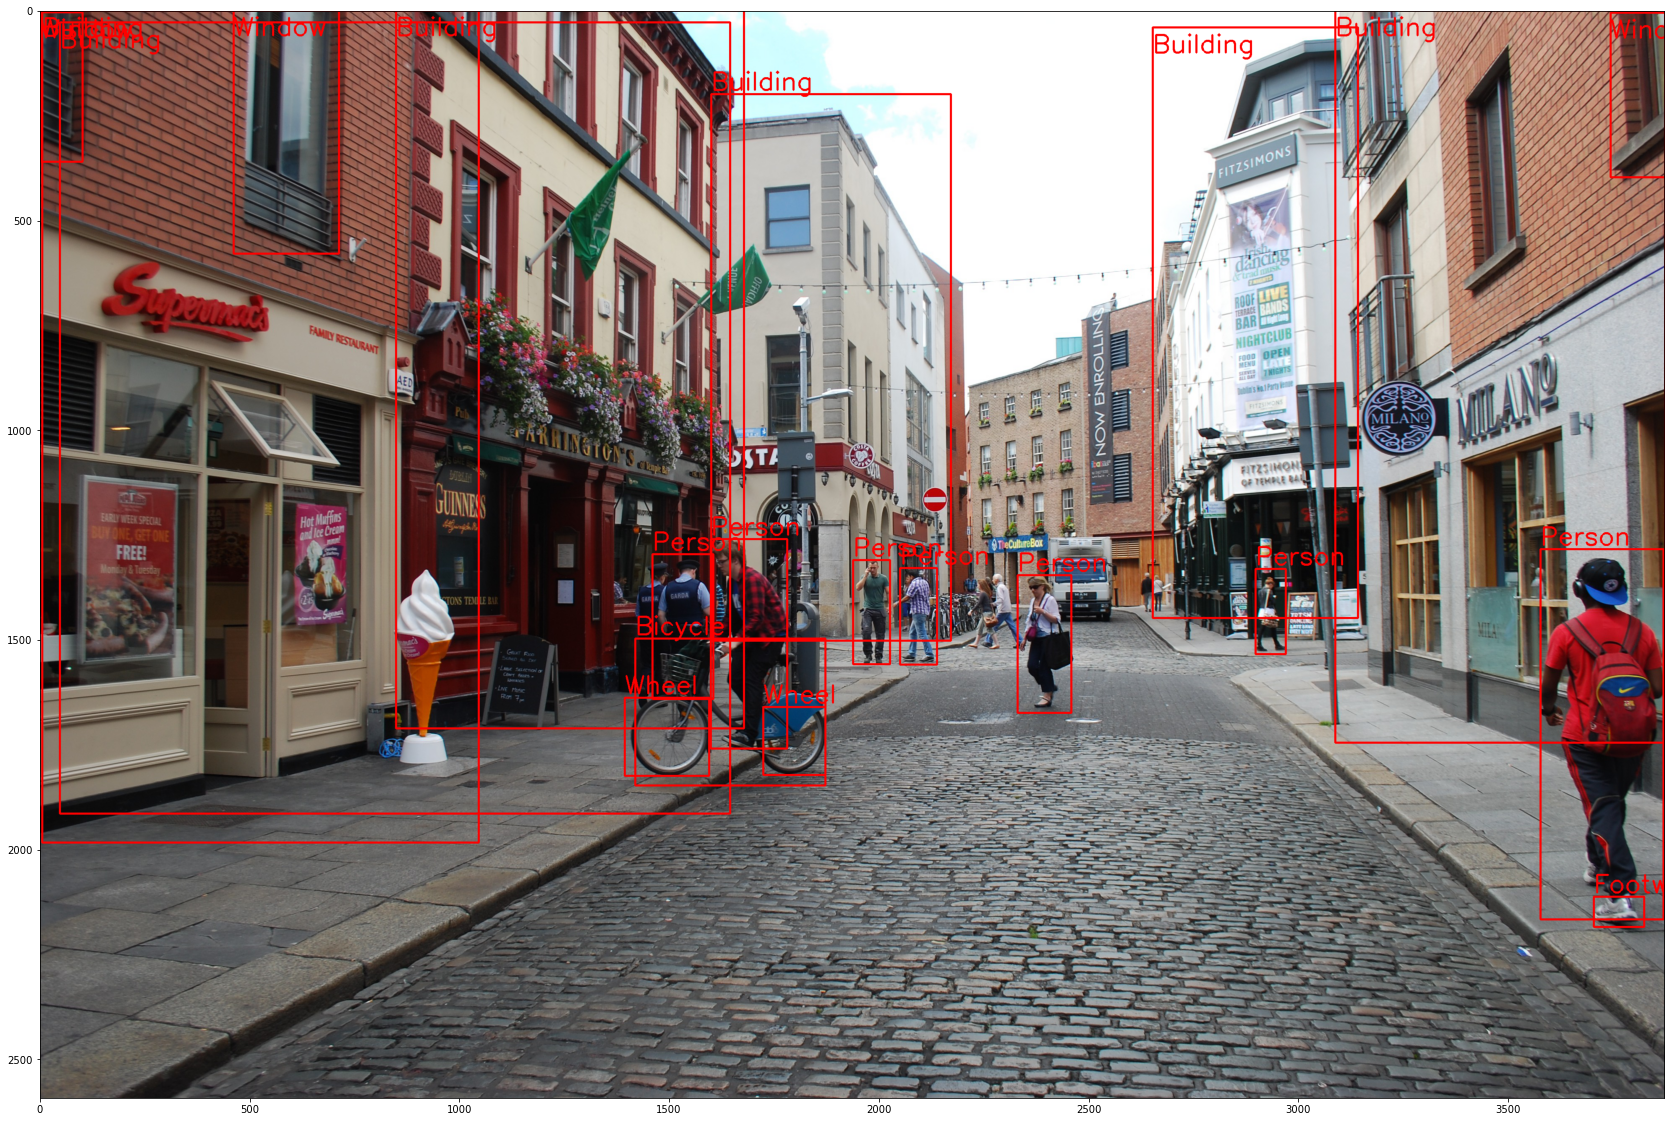

In [102]:
draw_bounding_boxes(img, result, 0.3)

(3872, 2592)